In [1]:
# Tell Jupyter to plot figure right in the page
%pip install hyperspy
# Module with plot capabilities
import matplotlib.pyplot as plt
import seaborn as sns
import hyperspy.api as hs

# Module with scientific computing functions (matrix/vector)
import numpy as np                

# Modules with reading/write folder/file functions
import os
from pathlib import Path
import SimpleITK as sitk

# module to deal with images
import uproot

# The following command display the current working directory (where jupyter has been launched)
cwd = os.getcwd()
print('The Current Working Directory (CWD) is: \n', cwd)
folder = Path()

# Display the content of a folder
output_folder = Path('./output')
if not output_folder.is_dir():
    print('ERROR: {} is not a folder.'.format(output_folder))
else:
    print('The folder and contains the following files:'.format(output_folder))
    p = output_folder.glob('**/*')
    files = [x for x in p if x.is_file()]
    for x in files:
        print(x)


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
The Current Working Directory (CWD) is: 
 /home/francesco/gate/VHEE_monitor
The folder and contains the following files:
output/phase_space80.0.root
output/dose3d_150_edep.mhd
output/dose3d_150_dose.mhd
output/dose3d_150_dose.raw
output/dose3d_150_edep.raw
output/gamma80.npy
output/dose3d_150_dose_uncertainty.raw
output/dose3d_150_dose_uncertainty.mhd
output/gamma150.npy
output/stats.txt
output/gamma150_hole.npy
output/phase_space150.0.root
output/phase_space150.root


In [4]:
# Set the filenames (d = depth, p = profile)
f_d_edep = output_folder / 'dose3d_150_dose.mhd'
f_d_uncert = output_folder / 'dose3d_150_dose_uncertainty.mhd'


In [5]:
# Load data from image files. 
# This is a 3 steps process:
# 1. Read the image file (with sitk.ReadImage)
# 2. Convert the image to a numpy array (with sitk.GetArrayFromImage)
# 3. Reshape the 3D image array to 1D (with reshape(-1))
d_edep = sitk.GetArrayFromImage(sitk.ReadImage(f_d_edep)).reshape(-1)




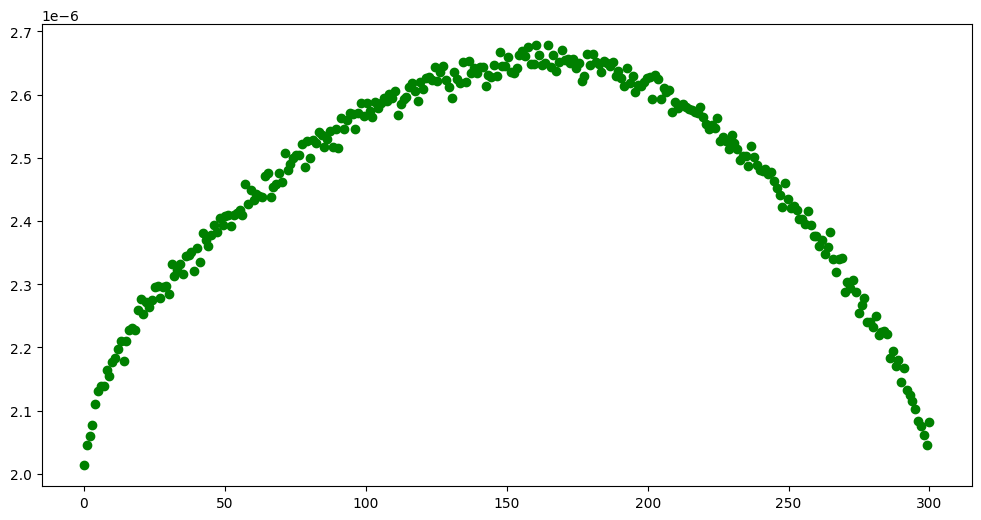

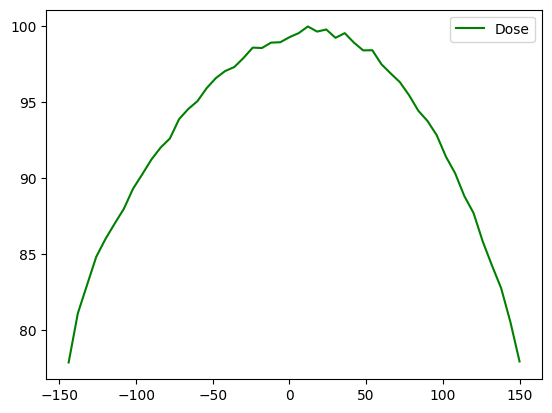

In [6]:
# Declare a single figure (one row, one column)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))

# X values from 0 to n, n is the length of d_edep
n = len(d_edep)
x = np.linspace(0, n, n)

# First curve, gamma depth in green
y = d_edep
plt.scatter(x, y, color='green', label='Dose')
plt.show()
# Convert the scatter plot to a histogram
histdose, bin_edges = np.histogram(x,weights=y, bins=50)
# Add labels and legend
histdose = (histdose/np.max(histdose))*100
bin_edges = np.linspace(-150, 150, len(bin_edges))
plt.plot(bin_edges[1:], histdose, color='green', label='Dose')

plt.legend()

# Show the plot
plt.show()

In [2]:
f = uproot.open('output/phase_space150.0.root')
print("List of tree : \n", f.keys())
ph = f['PhaseSpace']
print('Number of hits:', ph.num_entries)
print('ph keys: ')
for i in ph.keys():
    print(i, ' ', end='')

List of tree : 
 ['PhaseSpace;1']
Number of hits: 16832688.0
ph keys: 
KineticEnergy  PostPosition_X  PostPosition_Y  PostPosition_Z  PrePosition_X  PrePosition_Y  PrePosition_Z  PreDirection_X  PreDirection_Y  PreDirection_Z  EventPosition_X  EventPosition_Y  EventPosition_Z  

Text(0.5, 1.0, 'Angle with Z-axis')

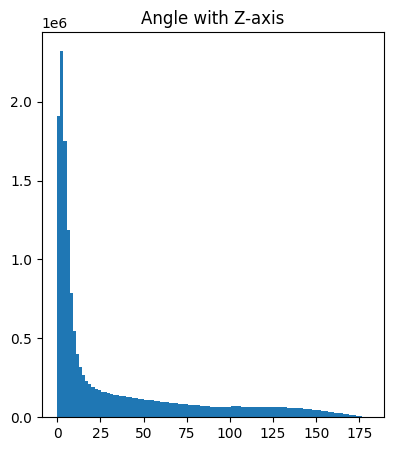

In [3]:
ppx=ph['PostPosition_X'].array()
ppy=ph['PostPosition_Y'].array()
ppz=ph['PostPosition_Z'].array()
pre_dir_x = np.array(ph.arrays()['PreDirection_X'])
pre_dir_y = np.array(ph.arrays()['PreDirection_Y'])
pre_dir_z = np.array(ph.arrays()['PreDirection_Z'])
kin = np.array(ph.arrays()['KineticEnergy'])

angle_with_z = np.arccos(pre_dir_z / np.linalg.norm([pre_dir_x, pre_dir_y, pre_dir_z], axis=0)) * 180 / np.pi

# Plot the histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 3)
plt.hist(angle_with_z, bins=100, range=(0, 180))
plt.title('Angle with Z-axis')


Number of hits: 149981


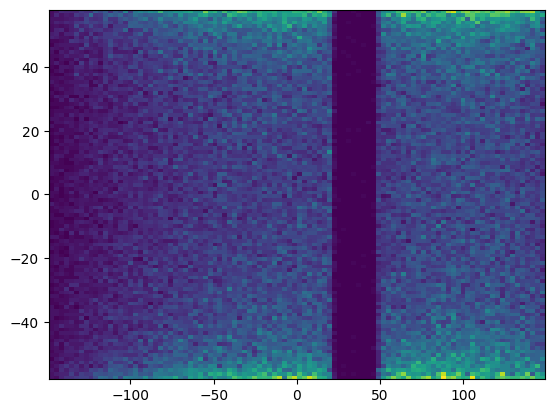

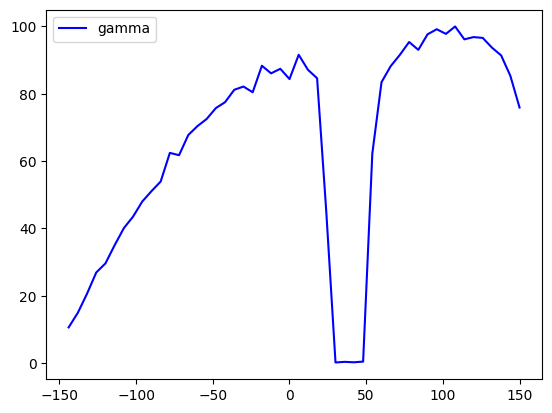

In [4]:
# Filter the data where ppx > 0
ppz = np.array(ppz)
ppy = np.array(ppy)
ppx = np.array(ppx)
# Select only elements within an angle with z of 90 degrees
angle_mask = np.logical_and(angle_with_z > 88, angle_with_z < 92)

filtered_ppz_angle = ppz[angle_mask]
filtered_ppy_angle = ppy[angle_mask]
filtered_ppx_angle = ppx[angle_mask]


print('Number of hits:', len(filtered_ppz_angle))

plt.hist2d(filtered_ppz_angle, filtered_ppy_angle, bins=(100,100), cmap='viridis',range=[[-149, 149], [-58, 58]])
plt.show()

h, xedges, yedges = np.histogram2d(filtered_ppz_angle, filtered_ppy_angle, bins=(50, 1), range=[[-149, 149], [-58, 58]])

h = np.reshape(h, (50))

histgamma = (h/np.max(h))*100
bin_edges_g = np.linspace(-150, 150, len(xedges))
plt.plot(bin_edges_g[1:], histgamma, color='blue', label='gamma')

plt.legend()

# Show the plot
plt.show()

np.save('output/gamma150_hole.npy', histgamma)

